# Data Loading

In [1]:
import os
import pandas as pd

In [2]:
master_folder = "../EMG_data_for_gestures-master"
cleaned_data_by_subject = {}

In [3]:
# Loop through each subject's folder
for subject_folder in sorted(os.listdir(master_folder)):
    subject_path = os.path.join(master_folder, subject_folder)

    if os.path.isdir(subject_path):  # Check if it's a directory
        subject_number = int(subject_folder)  # Convert subject folder name to an integer
        
        trials = []
        
        for file_name in sorted(os.listdir(subject_path)):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subject_path, file_name)
                
                # Load the .txt file with proper handling for mixed types and whitespace delimiter
                df = pd.read_csv(file_path, delim_whitespace=True, dtype=str)  # Load as strings to avoid dtype issues

                # Drop 'time' column
                df.drop('time', inplace=True, axis=1)
                
                # Drop rows where 'class' column has NaNs or non-numeric values
                df = df[df["class"].notna() & df["class"].str.isnumeric()]
                
                # Convert 'class' column to integer
                df["class"] = df["class"].astype(int)
                
                # Keep only relevant classes (1 to 6) and drop others
                df = df[df["class"].isin([1, 2, 3, 4, 5, 6])]
                
                # Append the cleaned trial data to the list
                trials.append(df)
        
        # Concatenate trials for the current subject
        subject_data = pd.concat(trials, axis=0).reset_index(drop=True)
        
        # Store the cleaned data for the subject
        cleaned_data_by_subject[subject_number] = subject_data

print(f"Loaded and cleaned data for {len(cleaned_data_by_subject)} subjects.")

Loaded and cleaned data for 36 subjects.


# Sliding Window - 1st CNN

In [4]:
import numpy as np
from scipy.stats import mode

In [5]:
# Function to apply sliding window segmentation
def create_sliding_windows(data, window_size=200, step_size=50):
    windows = []
    labels = []
    
    num_samples = len(data)
    
    for start in range(0, num_samples - window_size + 1, step_size):
        # Extract the window
        window = data.iloc[start:start + window_size, :-1].values  # All columns except the last (class label)
        label = data.iloc[start:start + window_size, -1]  # Class labels for the window
        
        # Assign the label as the mode (most frequent class) in the window
        window_label = mode(label).mode  # Extract mode value
        
        # Handle scalar or array output from mode
        if isinstance(window_label, np.ndarray):
            window_label = window_label[0]
        
        windows.append(window)
        labels.append(window_label)
    
    return np.array(windows), np.array(labels)

In [6]:
# Apply sliding windows for each subject
window_size = 200  # Adjust as needed
step_size = 50     # Adjust as needed

windowed_data_by_subject = {}

for subject_id, data in cleaned_data_by_subject.items():
    windows, labels = create_sliding_windows(data, window_size, step_size)
    windowed_data_by_subject[subject_id] = (windows, labels)

print("Sliding window segmentation completed.")

Sliding window segmentation completed.


In [7]:
# Initialize empty lists to hold combined data and labels
all_windows = []
all_labels = []

# Combine windows and labels from all subjects
for subject_id, (windows, labels) in windowed_data_by_subject.items():
    all_windows.append(windows)
    all_labels.append(labels)

# Concatenate the lists into arrays
all_windows = np.concatenate(all_windows, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(f"Total windows: {all_windows.shape[0]}, Total labels: {all_labels.shape[0]}")

Total windows: 29854, Total labels: 29854


In [8]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(all_windows, all_labels, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 23883, Testing samples: 5971


In [9]:
print("X_train.shape",X_train.shape)
print("X_test.shape",X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape",y_test.shape)

X_train.shape (23883, 200, 8)
X_test.shape (5971, 200, 8)
y_train.shape (23883,)
y_test.shape (5971,)


In [11]:
# Convert training and testing data to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)

In [18]:
# Zero-index the class labels by subtracting 1
y_train -= 1
y_test -= 1

print("Class labels have been zero-indexed.")

Class labels have been zero-indexed.


In [19]:
# Normalize the training and testing data using min-max normalization
X_train = (X_train - X_train.min(axis=(1, 2), keepdims=True)) / (X_train.max(axis=(1, 2), keepdims=True) - X_train.min(axis=(1, 2), keepdims=True) + 1e-8)
X_test = (X_test - X_test.min(axis=(1, 2), keepdims=True)) / (X_test.max(axis=(1, 2), keepdims=True) - X_test.min(axis=(1, 2), keepdims=True) + 1e-8)

print("Data normalization completed.")

Data normalization completed.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the CNN model function
def CNN_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Flattening layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Print the model summary
    model.summary()
    
    return model

In [21]:
# Define input shape and number of classes
input_shape = (X_train.shape[1], X_train.shape[2])  # (window_size, num_channels)
num_classes = len(np.unique(y_train))  # Assuming 6 classes (0 to 5)

# Create the CNN model
model = CNN_model(input_shape, num_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 198, 32)           800       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 99, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 97, 64)            6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 48, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [22]:
all_windows.shape

(29854, 200, 8)

In [23]:
# Train the CNN model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)
print("Model training completed.")

Epoch 1/20
747/747 [==============================] - 4s 5ms/step - loss: 1.0310 - accuracy: 0.5998 - val_loss: 0.7954 - val_accuracy: 0.7031
Epoch 2/20
747/747 [==============================] - 3s 4ms/step - loss: 0.7086 - accuracy: 0.7363 - val_loss: 0.6851 - val_accuracy: 0.7426
Epoch 3/20
747/747 [==============================] - 3s 4ms/step - loss: 0.6137 - accuracy: 0.7663 - val_loss: 0.6484 - val_accuracy: 0.7553
Epoch 4/20
747/747 [==============================] - 3s 4ms/step - loss: 0.5519 - accuracy: 0.7882 - val_loss: 0.6138 - val_accuracy: 0.7734
Epoch 5/20
747/747 [==============================] - 3s 4ms/step - loss: 0.4851 - accuracy: 0.8125 - val_loss: 0.6013 - val_accuracy: 0.7701
Epoch 6/20
747/747 [==============================] - 3s 5ms/step - loss: 0.4275 - accuracy: 0.8338 - val_loss: 0.6162 - val_accuracy: 0.7776
Epoch 7/20
747/747 [==============================] - 3s 5ms/step - loss: 0.3746 - accuracy: 0.8569 - val_loss: 0.6042 - val_accuracy: 0.7813
Epoch 

In [24]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.3058
Test Accuracy: 0.7650


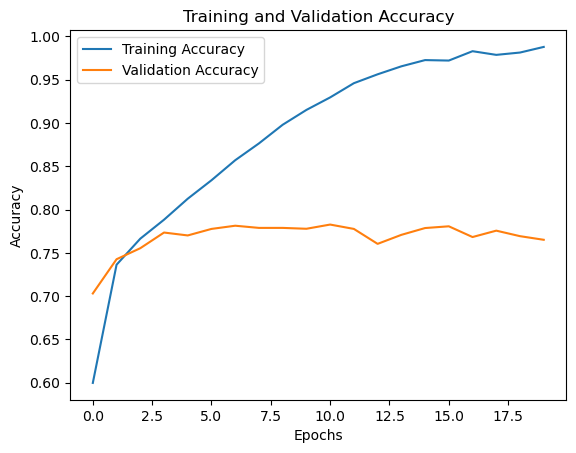

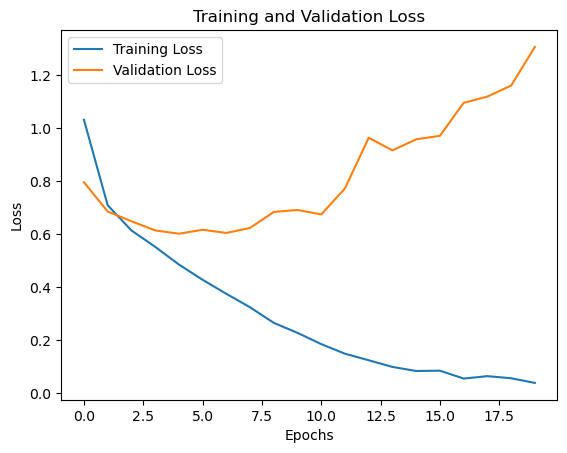

In [25]:
import matplotlib.pyplot as plt

# Plot accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()